In [1]:
# !pip install tueplots
# !pip install backports.strenum
# !pip install nncore
# !pip install StrEnum

In [2]:
import os
import itertools
import random
from typing import Sequence

import matplotlib.pyplot as plt
import torch
from pathlib import Path
from pytorch_lightning import seed_everything
from torch.nn import functional as F
import numpy as np

try:
    # be ready for 3.10 when it drops
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum
from enum import auto

# from nn_core.common import PROJECT_ROOT
import pickle

print(os.path.abspath(os.curdir))
os.chdir("..")
print(os.path.abspath(os.curdir))
from zeroshotrl.rl_agents.ppo.ppo_end_to_end_relu_stack_align import FeatureExtractor
from zeroshotrl.utils.relative import *
from zeroshotrl.utils.notebooks import *

/home/antonioricciardi/projects/rl_relrepr_gymnasium/notebooks
/home/antonioricciardi/projects/rl_relrepr_gymnasium


In [3]:
# DATA_DIR: Path = PROJECT_ROOT / "data"

In [4]:
from tueplots import bundles

# plt.rcParams.update(bundles.icml2022())
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

In [5]:
CMAP = "jet"

In [6]:
# DATA_DIR: Path = PROJECT_ROOT

In [7]:
color1 = "green"
color2 = "green"
enc1_seed = 1
enc2_seed = 1

anchors_env_id1 = "CarRacing-v2"
anchors_env_id2 = "CarRacing-v2-bus"
anchors_path1 = f"data/anchors/{anchors_env_id1}/rgb_ppo_transitions_green_obs.pkl"
anchors_path2 = f"data/anchors/{anchors_env_id2}/rgb_ppo_transitions_green_obs.pkl"

obs_env_id1 = "CarRacing-v2"
obs_env_id2 = "CarRacing-v2-bus"
obs_path1 = f"data/anchors/{obs_env_id1}/rgb_ppo_transitions_{color1}_obs.pkl"
obs_path2 = f"data/anchors/{obs_env_id2}/rgb_ppo_transitions_{color2}_obs.pkl"

algo1 = "ppo"
algo2 = "ppo"
env_id1 = "CarRacing-v2"
env_id2 = "CarRacing-v2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# encoder1_path = torch.load(
#     f"models/{env_id1}/rgb/{color1}/{algo1}/absolute/relu/seed_{enc1_seed}/encoder.pt",
#     map_location=device,
# )
# encoder2_path = torch.load(
#     f"models/{env_id2}/rgb/{color2}/{algo2}/absolute/relu/seed_{enc2_seed}/encoder.pt",
#     map_location=device,
# )

In [8]:
# encoder1 = FeatureExtractor()
# encoder2 = FeatureExtractor()
# encoder1.load_state_dict(encoder1_path)
# encoder2.load_state_dict(encoder2_path)

from torchvision import models

# Initialize ResNet-18 models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = models.resnet18(weights=True).to(device)
# encoder2 = models.resnet18(pretrained=True).to(device)

# Optionally set models to evaluation mode if they are used for feature extraction
encoder.eval()

# Hook to extract intermediate features
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output
    return hook

# Register hook for desired layer (e.g., layer4 or avgpool)
layer_name = "layer4"  # Change to avgpool for the global representation
getattr(encoder, layer_name).register_forward_hook(get_features(layer_name))

# Pass an input image
# input_tensor = torch.rand(1, 3, 224, 224).to(device)  # Example input
# with torch.no_grad():
#     encoder(input_tensor)

# # Extract features
# extracted_features = features[layer_name]
# print(extracted_features.shape)  # Shape depends on the chosen layer

/home/antonioricciardi/projects/rl_relrepr_gymnasium/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
obs_set_1 = pickle.load(Path(obs_path1).open("rb"))  # [30:2000]
obs_set_2 = pickle.load(Path(obs_path2).open("rb"))  # [30:2000]
print("\n#####\nObs loaded\n#####\n")

anchors_set_1 = pickle.load(Path(anchors_path1).open("rb"))
anchors_set_2 = pickle.load(Path(anchors_path2).open("rb"))
anchors_set_1 = torch.tensor(np.array(anchors_set_1), dtype=torch.float32)
anchors_set_2 = torch.tensor(np.array(anchors_set_2), dtype=torch.float32)
# subset_indices = np.random.randint(0, len(obs_set_1), 5000)
obs_set_1 = obs_set_1
obs_set_2 = obs_set_2

print("Converting obs to torch tensor")
# convert the (4000, 3, 84, 84) numpy array to a torch tensor
obs_set_1 = torch.tensor(np.array(obs_set_1), dtype=torch.float32)
obs_set_2 = torch.tensor(np.array(obs_set_2), dtype=torch.float32)
print("Done converting obs to torch tensor\n#####\n")

# obs_set_1 = torch.cat([obs_set_1, obs_set_2], dim=0)  # [anch_indices
# obs_set_2 = obs_set_1

subset_indices = np.arange(len(obs_set_1))  # [:4000]

# obs_set_1 = torch.cat(obs_set_1, dim=0).cpu()  # [anch_indices]
# obs_set_2 = torch.cat(obs_set_2, dim=0).cpu()  # [anch_indices]
space1 = encoder(obs_set_1[:900].to(device)).detach().cpu()
space2 = encoder(obs_set_2[:900].to(device)).detach().cpu()




#####
Obs loaded
#####

Converting obs to torch tensor
Done converting obs to torch tensor
#####



In [10]:
anchors_set_1.shape, anchors_set_2.shape, obs_set_1.shape, obs_set_2.shape, space1.shape, space2.shape

(torch.Size([4000, 3, 84, 84]),
 torch.Size([4000, 3, 84, 84]),
 torch.Size([4000, 3, 84, 84]),
 torch.Size([4000, 3, 84, 84]),
 torch.Size([900, 1000]),
 torch.Size([900, 1000]))

In [11]:
obs_set_1.max()
obs_set_2.max()

tensor(0.9922)

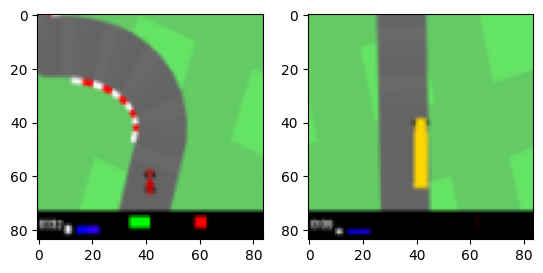

In [12]:
# plot obs_set_1 and obs_set_2 images in a subplot
i = 350

fig, ax = plt.subplots(1, 2)
ax[0].imshow(obs_set_1[i].permute(1, 2, 0))
ax[1].imshow(obs_set_2[i].permute(1, 2, 0))
plt.show()

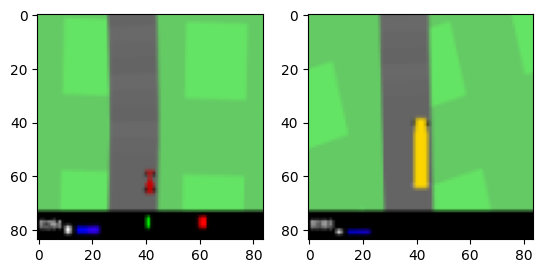

In [13]:
i = 300
fig, ax = plt.subplots(1, 2)
ax[0].imshow(anchors_set_1[i].permute(1, 2, 0))
ax[1].imshow(anchors_set_2[i].permute(1, 2, 0))
plt.show()

In [14]:
assert space1.shape == space2.shape
# assert space1.size(0) == labels.size(0)
space1.shape

torch.Size([900, 1000])

In [15]:
norm_space1: torch.Tensor = F.normalize(space1, p=2, dim=-1)
norm_space2: torch.Tensor = F.normalize(space2, p=2, dim=-1)

assert norm_space1.shape == norm_space2.shape

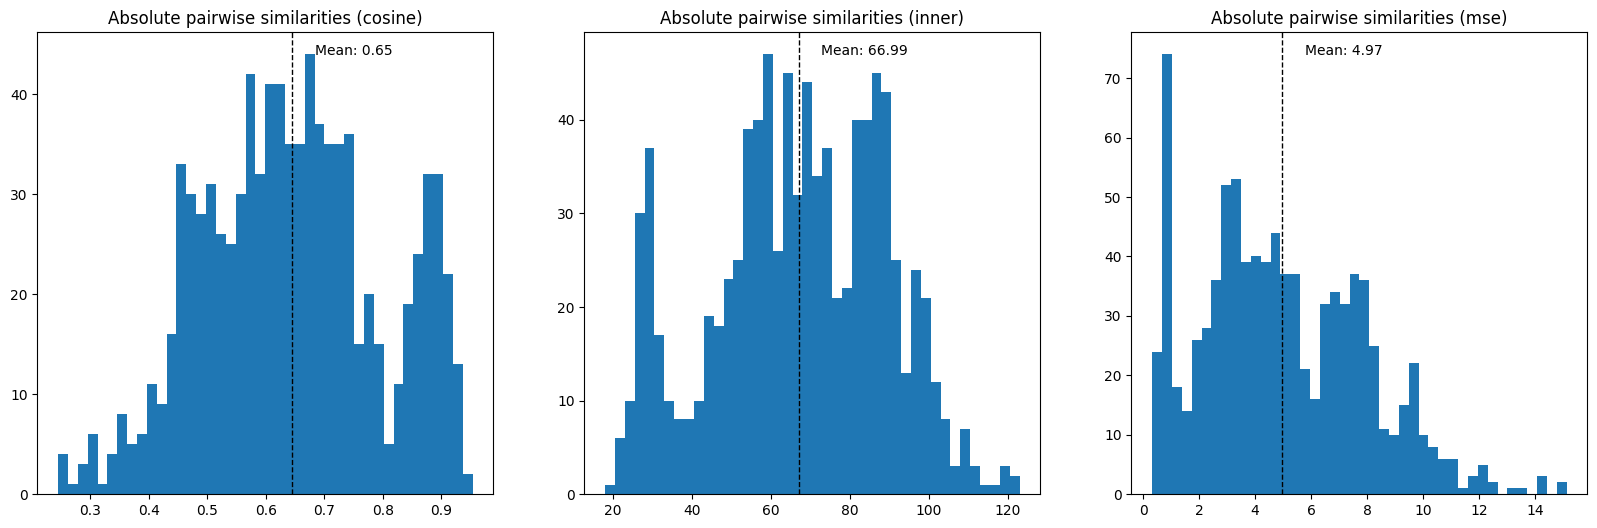

In [16]:
plot_pairwise_dist(space1=space1, space2=space2, prefix="Absolute")

In [17]:
self_sim_comparison(space1=space1, space2=space2, normalize=True)

{'spearman_mean': 0.1036791130900383,
 'spearman_std': 0.16311180591583252,
 'pearson_mean': 0.1857122927904129,
 'pearson_std': 0.17295445501804352,
 'cosine_mean': 0.9688078761100769,
 'cosine_std': 0.013796228915452957}

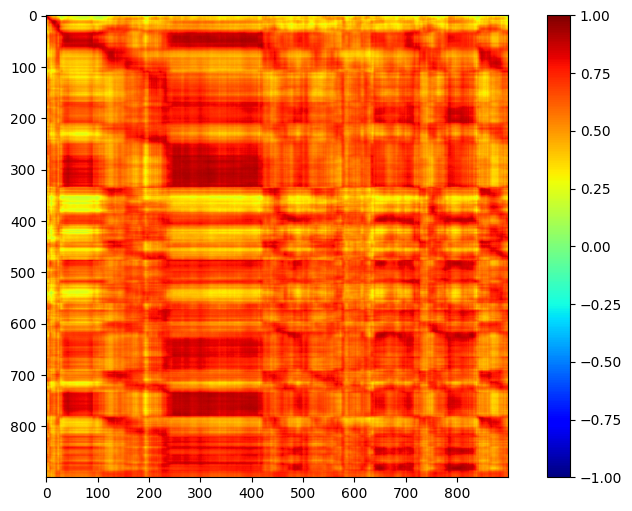

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=False)
dist_method = DistMethod.COSINE
prefix = "Absolute"
dists = all_dist(space1=space1, space2=space2, method=dist_method)
# ax.set_title(f"{prefix} self-similarities ({dist_method})")
img = ax.imshow(dists, cmap=CMAP, vmin=-1, vmax=1)  # Set vmin and vmax to -1 and 1
plt.colorbar(img, ax=ax)
plt.savefig(
    f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_abs_selfsim.pdf",
    bbox_inches="tight",
)

In [19]:
# randomly sample 1000 anchors from each set
random_indexing = torch.randperm(anchors_set_1.size(0))[:1000]

anchors_space1 = encoder(anchors_set_1[random_indexing].to(device)).detach().cpu()
anchors_space2 = encoder(anchors_set_2[random_indexing].to(device)).detach().cpu()

# anchors_space1 = anchors_space1[random_indexing]
# anchors_space2 = anchors_space2[random_indexing]

# center anchors
anchors_space1_mean = anchors_space1.mean(dim=0)
anchors_space2_mean = anchors_space2.mean(dim=0)

center_anchor_translations = torch.cdist(
    anchors_space1_mean.unsqueeze(0), anchors_space2_mean.unsqueeze(0), p=2
)

anchors_space1 = anchors_space1 - anchors_space1.mean(
    dim=0
)  # / anchors_space1.std(dim=0)
anchors_space2 = anchors_space2 - anchors_space2.mean(
    dim=0
)  # / anchors_space2.std(dim=0)
center_anchor_translations = torch.cdist(
    anchors_space1.mean(dim=0, keepdim=True),
    anchors_space2.mean(dim=0, keepdim=True).unsqueeze(0),
    p=2,
)

norm_anchors_space1: torch.Tensor = F.normalize(anchors_space1, p=2, dim=-1)
norm_anchors_space2: torch.Tensor = F.normalize(anchors_space2, p=2, dim=-1)

assert norm_anchors_space1.shape == norm_anchors_space2.shape


norm_space1 = space1 - anchors_space1_mean  #  / self.anchors_std
norm_space1: torch.Tensor = F.normalize(norm_space1, p=2, dim=-1)

norm_space2 = space2 - anchors_space2_mean  #  / self.anchors_std
norm_space2: torch.Tensor = F.normalize(norm_space2, p=2, dim=-1)

In [20]:
space1.shape

torch.Size([900, 1000])

In [21]:
rel_space1 = norm_space1 @ anchors_space1.T  # space1_anchors.T
rel_space2 = norm_space2 @ anchors_space2.T  # space2_anchors.T

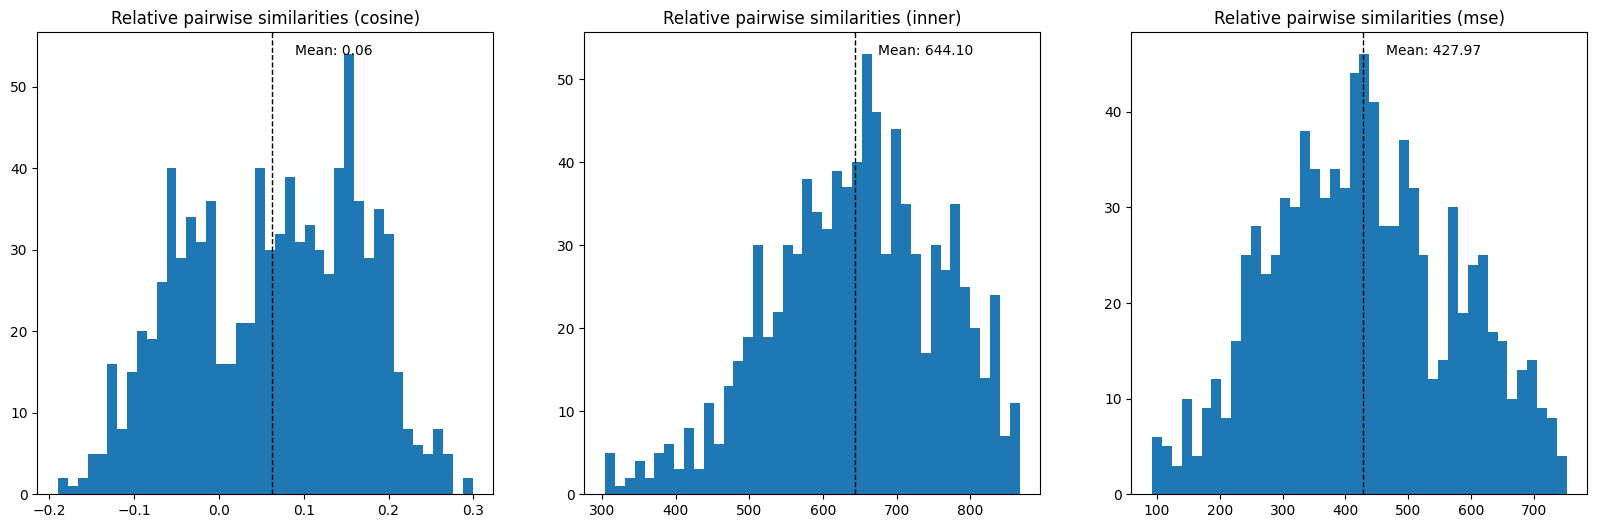

In [22]:
fig = plot_pairwise_dist(space1=rel_space1, space2=rel_space2, prefix="Relative")
# save fig
# fig.savefig(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_pairwise_dist_rel.pdf", bbox_inches='tight')
fig

In [23]:
self_sim_comparison(space1=rel_space1, space2=rel_space2, normalize=True)

{'spearman_mean': 0.0828952044248581,
 'spearman_std': 0.14568214118480682,
 'pearson_mean': 0.06870143115520477,
 'pearson_std': 0.13825799524784088,
 'cosine_mean': 0.0736035481095314,
 'cosine_std': 0.12594033777713776}

In [24]:
# plot_self_dist(space1=rel_space1, space2=rel_space2, prefix="Relative")

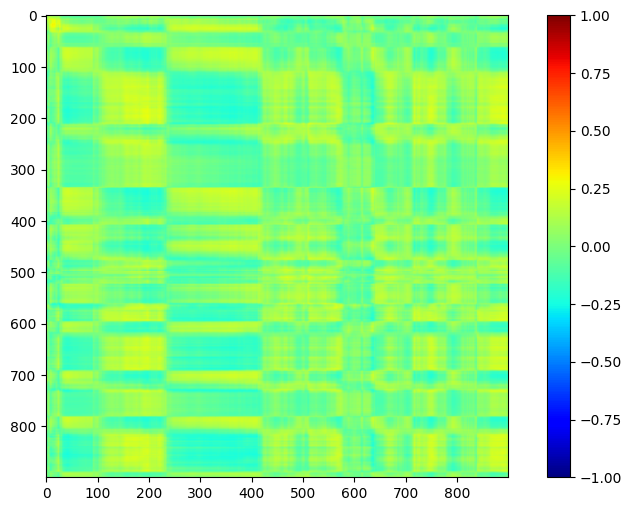

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=False)
dist_method = DistMethod.COSINE
prefix = "Relative"
dists = all_dist(space1=rel_space1, space2=rel_space2, method=dist_method)
# ax.set_title(f"{prefix} self-similarities ({dist_method})")
img = ax.imshow(dists, cmap=CMAP, vmin=-1, vmax=1)  # Set vmin and vmax to -1 and 1
plt.colorbar(img, ax=ax)
# plt.savefig(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_rel_selfsim.pdf", bbox_inches='tight')

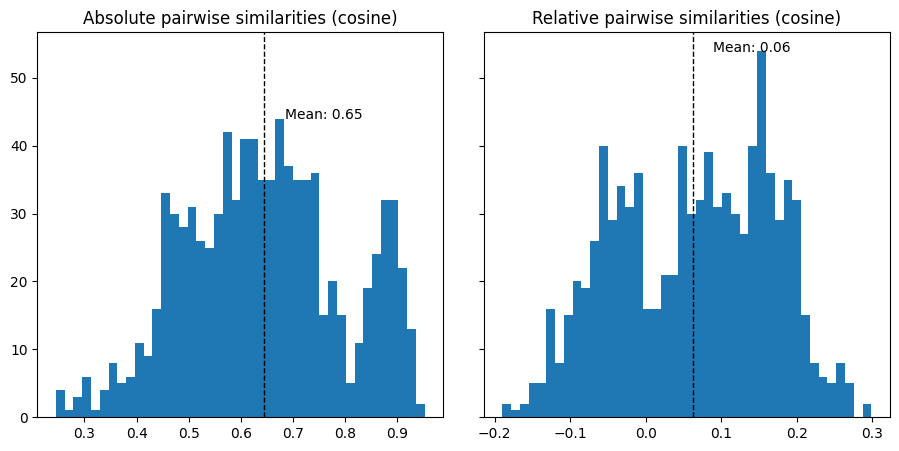

In [26]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(11, 5), sharey=True, gridspec_kw={"wspace": 0.1}
)

dist_method = DistMethod.COSINE
prefix = "Absolute"
dists = pairwise_dist(space1=space1, space2=space2, method=dist_method)
axs[0].hist(dists, bins=42)
axs[0].set_title(f"{prefix} pairwise similarities ({dist_method})")
axs[0].axvline(dists.mean(), color="k", linestyle="dashed", linewidth=1)

min_ylim, max_ylim = axs[0].get_ylim()
min_xlim, max_xlim = axs[0].get_xlim()
axs[0].text(
    dists.mean() + (max_xlim - min_xlim) / 20,
    max_ylim * 0.95,
    "Mean: {:.2f}".format(dists.mean()),
)

prefix = "Relative"
dists = pairwise_dist(space1=rel_space1, space2=rel_space2, method=dist_method)
axs[1].hist(dists, bins=42)
axs[1].set_title(f"{prefix} pairwise similarities ({dist_method})")
axs[1].axvline(dists.mean(), color="k", linestyle="dashed", linewidth=1)

min_ylim, max_ylim = axs[1].get_ylim()
min_xlim, max_xlim = axs[1].get_xlim()
axs[1].text(
    dists.mean() + (max_xlim - min_xlim) / 20,
    max_ylim * 0.95,
    "Mean: {:.2f}".format(dists.mean()),
)

plt.close()

# fig.savefig(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_pairwise_dists_abs_rel.pdf", bbox_inches='tight')

fig

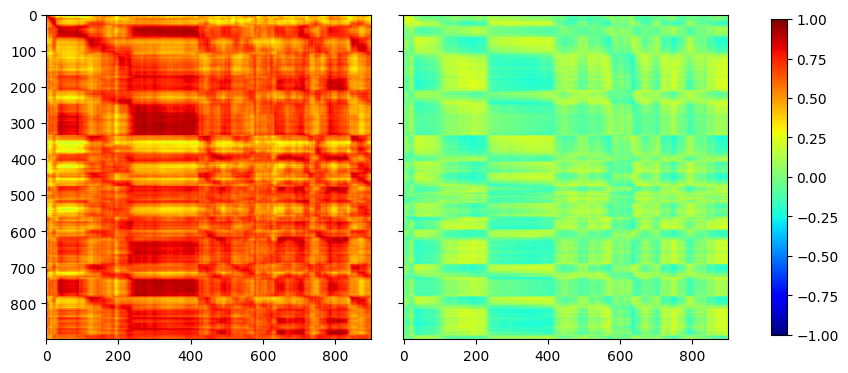

In [27]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(11, 5), sharey=True, gridspec_kw={"wspace": 0.1}
)

# Plot Absolute Self-Similarities
dist_method = DistMethod.COSINE
prefix = "Absolute"
dists = all_dist(space1=space1, space2=space2, method=dist_method)
# axs[0].set_title(f"{prefix} self-similarities ({dist_method})")
img1 = axs[0].imshow(dists, cmap="jet", vmin=-1, vmax=1)  # cmap='Spectral_r'

# Plot Relative Self-Similarities
dist_method = DistMethod.COSINE
prefix = "Relative"
dists = all_dist(space1=rel_space1, space2=rel_space2, method=dist_method)
# axs[1].set_title(f"{prefix} self-similarities ({dist_method})")
img2 = axs[1].imshow(dists, cmap="jet", vmin=-1, vmax=1)

# Add a smaller colorbar
fig.colorbar(img2, ax=axs, orientation="vertical", shrink=0.82)

# Save the figure
# plt.savefig(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_selfsim.pdf", bbox_inches='tight')

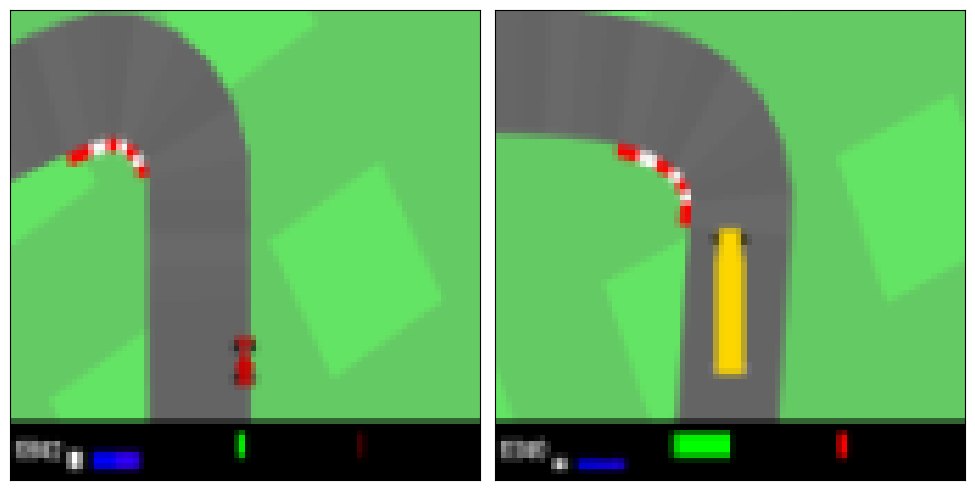

In [28]:
# plot frame i and frame j in a subplot
i = 700
j = 860
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={"wspace": 0})
ax[0].imshow(obs_set_1[i].permute(1, 2, 0))
ax[1].imshow(obs_set_2[j].permute(1, 2, 0))

# Hide ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.tight_layout()
# plt.show()

# save image to file
# plt.savefig(f"experiments/plots/{env_id1}_{color1}_{env_id2}_{color2}_frames.pdf", bbox_inches='tight')

# Additional Analysis of the Latent Space

In [29]:
class Reduction(StrEnum):
    INDEPENDENT_PCA = auto()
    SHARED_PCA = auto()
    TSNE = auto()
    # UMAP = auto()
    FIRST_DIMS = auto()

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def reduce(
    space1: torch.Tensor, space2: torch.Tensor, reduction: Reduction, seed: int = 42
):
    if reduction == Reduction.INDEPENDENT_PCA:
        space1 = PCA(2, random_state=seed).fit_transform(space1)
        space2 = PCA(2, random_state=seed).fit_transform(space2)
    elif reduction == Reduction.SHARED_PCA:
        pca = PCA(2, random_state=seed)
        space1 = pca.fit_transform(space1)
        space2 = pca.transform(space2)
    elif reduction == Reduction.TSNE:
        space1 = TSNE(
            2, random_state=seed, learning_rate="auto", init="pca"
        ).fit_transform(space1)
        space2 = TSNE(
            2, random_state=seed, learning_rate="auto", init="pca"
        ).fit_transform(space2)
    elif reduction == Reduction.FIRST_DIMS:
        space1 = space1[:, [0, 1]]
        space2 = space2[:, [0, 1]]
    else:
        raise NotImplementedError

    return space1, space2

In [31]:
def plot_space_grid(
    x_header: Sequence[str],
    y_header: Sequence[str],
    spaces: Sequence[Sequence[np.ndarray]],
    c=None,
    cmap=CMAP,
):
    """Plots a grid of scatter plots using matplotlib.

    Args:
        x_header: A sequence of strings for the x-axis labels.
        y_header: A sequence of strings for the y-axis labels.
        spaces: A sequence of sequences of tensors containing the data to be plotted.
        c: Optional. The colors of the plotted points.
        cmap: The colormap to use for the plotted points.
    Returns:
        The figure object representing the complete plot.
    """
    n_rows = len(spaces)
    n_cols = len(spaces[0])

    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5)
    )

    for x, row in zip(x_header, axs):
        row[0].set_ylabel(x, rotation=90, size="xx-large")

    for y, col in zip(y_header, axs[0]):
        col.set_title(y, size="xx-large")

    for i, j in itertools.product(range(n_rows), range(n_cols)):
        space = spaces[i][j]
        assert space.shape[1] == 2
        axs[i, j].scatter(x=space[:, 0], y=space[:, 1], c=c, cmap=cmap)

    plt.close()
    return fig

In [32]:
x_header = [reduction.upper() for reduction in Reduction]
y_header = [
    "Absolute Space 1",
    "Absolute Space 2",
    "Relative Space 1",
    "Relative Space 2",
]

spaces = [
    [
        *reduce(space1=space1, space2=space2, reduction=reduction),
        *reduce(space1=rel_space1, space2=rel_space2, reduction=reduction),
    ]
    for reduction in Reduction
]

In [33]:
# labels = torch.arange(space1.shape[0])
# load actions list as labels
labels_pth = "data/actions_lists/CarRacing-v2_actions_4000.pkl"
labels = pickle.load(Path(labels_pth).open("rb"))[:900]

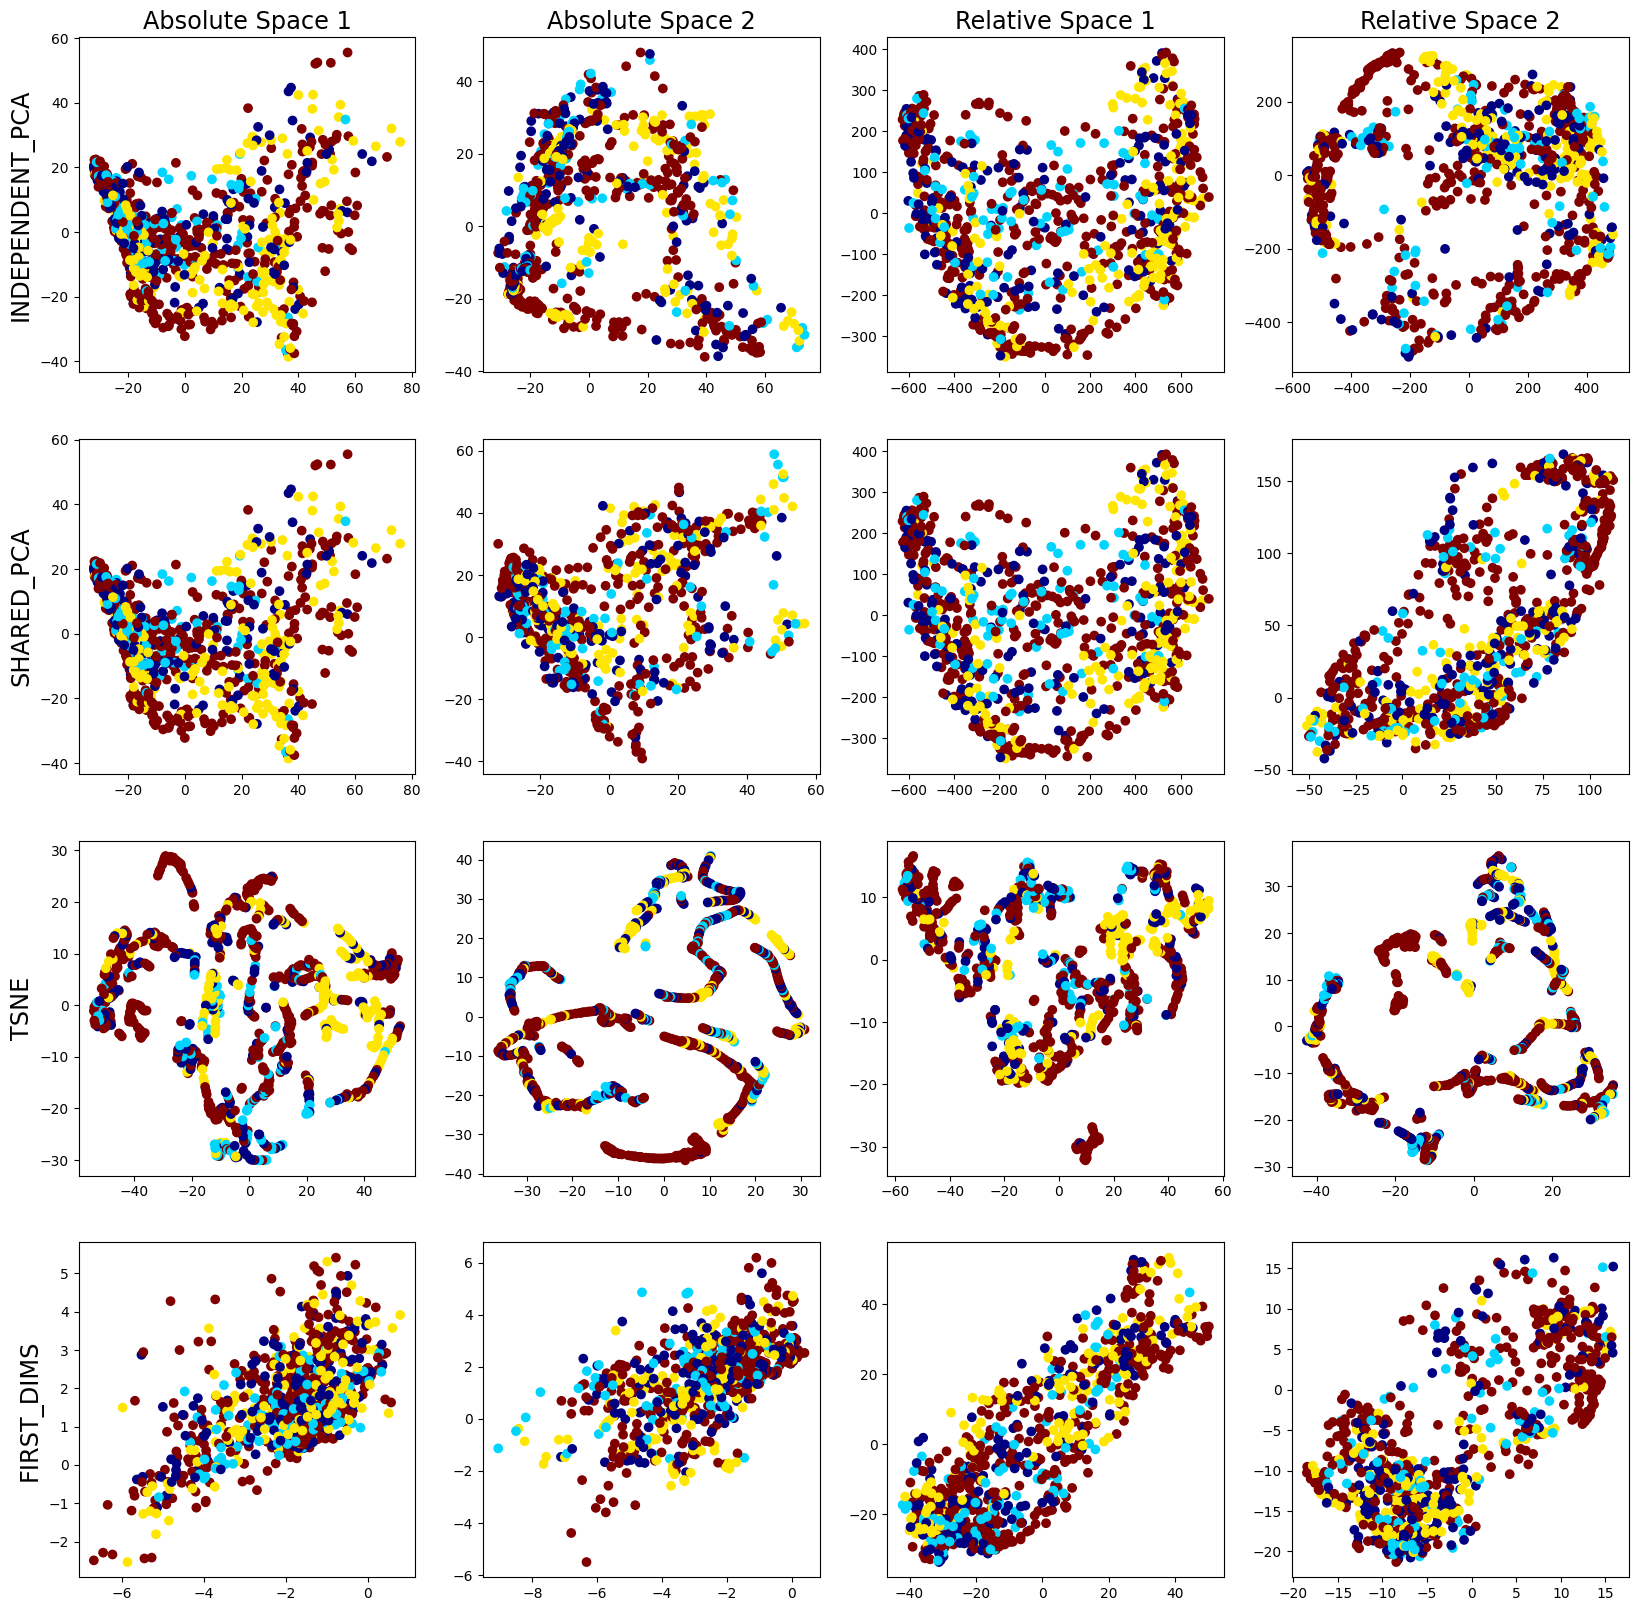

In [34]:
plot_space_grid(x_header=x_header, y_header=y_header, spaces=spaces[:200], c=labels)

In [35]:
sample_limit: int = None

In [36]:
# sort the items by class
sort_indices: torch.Tensor = labels[:sample_limit].sort().indices
abs_space1: torch.Tensor = abs_space1[sort_indices, :]
abs_space2: torch.Tensor = abs_space2[sort_indices, :]
labels: torch.Tensor = labels[sort_indices]

assert abs_space1.shape == abs_space2.shape
assert abs_space1.size(0) == labels.size(0)
abs_space1.shape

AttributeError: 'NoneType' object has no attribute 'indices'

In [ ]:
norm_abs_space1: torch.Tensor = F.normalize(abs_space1, p=2, dim=-1)
norm_abs_space2: torch.Tensor = F.normalize(abs_space2, p=2, dim=-1)

assert norm_abs_space1.shape == norm_abs_space2.shape

In [ ]:
class DistMethod(StrEnum):
    COSINE = auto()
    INNER = auto()
    MSE = auto()

In [ ]:
from torch.nn.functional import mse_loss, pairwise_distance
from torchmetrics.functional import pearson_corrcoef, spearman_corrcoef
from torch import cosine_similarity

In [ ]:
def self_sim_comparison(
    space1: torch.Tensor,
    space2: torch.Tensor,
    normalize: bool = False,
):
    if normalize:
        space1 = F.normalize(space1, p=2, dim=-1)
        space2 = F.normalize(space2, p=2, dim=-1)

    self_sim1 = space1 @ space1.T
    self_sim2 = space2 @ space2.T

    spearman = spearman_corrcoef(self_sim1.T, self_sim2.T)
    pearson = pearson_corrcoef(self_sim1.T, self_sim2.T)
    cosine = cosine_similarity(self_sim1, self_sim2)

    return dict(
        spearman_mean=spearman.mean().item(),
        spearman_std=spearman.std().item(),
        pearson_mean=pearson.mean().item(),
        pearson_std=pearson.std().item(),
        cosine_mean=cosine.mean().item(),
        cosine_std=cosine.std().item(),
    )


def pairwise_dist(space1: torch.Tensor, space2: torch.Tensor, method: DistMethod):
    if method == DistMethod.COSINE:
        dists = cosine_similarity(space1, space2)
    elif method == DistMethod.INNER:
        dists = pairwise_distance(space1, space2, p=2)
    elif method == DistMethod.MSE:
        dists = mse_loss(space1, space2, reduction="none").mean(dim=1)
    else:
        raise NotImplementedError

    return dists


def all_dist(space1: torch.Tensor, space2: torch.Tensor, method: DistMethod):
    if method == DistMethod.COSINE:
        space1 = F.normalize(space1, p=2, dim=-1)
        space2 = F.normalize(space2, p=2, dim=-1)
        dists = space1 @ space2.T
    elif method == DistMethod.INNER:
        dists = space1 @ space2.T
    elif method == DistMethod.MSE:
        dists = ((space1[:, None, :] - space2[None, :, :]) ** 2).mean(dim=-1)
    else:
        raise NotImplementedError

    return dists

In [ ]:
def plot_pairwise_dist(space1: torch.Tensor, space2: torch.Tensor, prefix: str):
    fig, axs = plt.subplots(
        nrows=1, ncols=len(DistMethod), figsize=(20, 6), sharey=False
    )
    for dist_method, ax in zip(DistMethod, axs):
        dists = pairwise_dist(space1=space1, space2=space2, method=dist_method)
        ax.hist(dists, bins=42)
        ax.set_title(f"{prefix} pairwise similarities ({dist_method})")
        ax.axvline(dists.mean(), color="k", linestyle="dashed", linewidth=1)

        min_ylim, max_ylim = ax.get_ylim()
        min_xlim, max_xlim = ax.get_xlim()
        ax.text(
            dists.mean() + (max_xlim - min_xlim) / 20,
            max_ylim * 0.95,
            "Mean: {:.2f}".format(dists.mean()),
        )

    plt.close()

    return fig


def plot_self_dist(space1: torch.Tensor, space2: torch.Tensor, prefix: str):
    fig, axs = plt.subplots(
        nrows=2, ncols=len(DistMethod), figsize=(20, 11), sharey=False
    )
    for dist_method, ax in zip(DistMethod, axs[0]):
        dists = all_dist(space1=space1, space2=space2, method=dist_method)
        ax.set_title(f"{prefix} self-similarities ({dist_method})")
        img = ax.imshow(dists, cmap=CMAP)
        plt.colorbar(img, ax=ax)

    for dist_method, ax in zip(DistMethod, axs[1]):
        dists = all_dist(
            space1=F.normalize(space1, p=2, dim=-1),
            space2=F.normalize(space2, p=2, dim=-1),
            method=dist_method,
        )
        ax.set_title(f"L2({prefix}) self-similarities ({dist_method})")
        img = ax.imshow(dists, cmap=CMAP)
        plt.colorbar(img, ax=ax)

    plt.close()

    return fig

In [ ]:
plot_pairwise_dist(space1=abs_space1, space2=abs_space2, prefix="Absolute")

In [ ]:
self_sim_comparison(space1=abs_space1, space2=abs_space2, normalize=True)

In [ ]:
plot_self_dist(space1=abs_space1, space2=abs_space2, prefix="Absolute")

In [ ]:
num_anchors: int = abs_space1.size(1)

seed_everything(42)
anchor_idxs = list(range(abs_space1.size(0)))
random.shuffle(anchor_idxs)
anchor_idxs = anchor_idxs[:num_anchors]

space1_anchors = norm_abs_space1[anchor_idxs, :]
space2_anchors = norm_abs_space2[anchor_idxs, :]

In [ ]:
rel_space1 = norm_abs_space1 @ space1_anchors.T
rel_space2 = norm_abs_space2 @ space2_anchors.T

In [ ]:
plot_pairwise_dist(space1=rel_space1, space2=rel_space2, prefix="Relative")

In [ ]:
self_sim_comparison(space1=rel_space1, space2=rel_space2, normalize=True)

In [ ]:
plot_self_dist(space1=rel_space1, space2=rel_space2, prefix="Absolute")

In [ ]:
class Reduction(StrEnum):
    INDEPENDENT_PCA = auto()
    SHARED_PCA = auto()
    TSNE = auto()
    # UMAP = auto()
    FIRST_DIMS = auto()

In [ ]:
def reduce(
    space1: torch.Tensor, space2: torch.Tensor, reduction: Reduction, seed: int = 42
):
    if reduction == Reduction.INDEPENDENT_PCA:
        space1 = PCA(2, random_state=seed).fit_transform(space1)
        space2 = PCA(2, random_state=seed).fit_transform(space2)
    elif reduction == Reduction.SHARED_PCA:
        pca = PCA(2, random_state=seed)
        space1 = pca.fit_transform(space1)
        space2 = pca.transform(space2)
    elif reduction == Reduction.TSNE:
        space1 = TSNE(
            2, random_state=seed, learning_rate="auto", init="pca"
        ).fit_transform(space1)
        space2 = TSNE(
            2, random_state=seed, learning_rate="auto", init="pca"
        ).fit_transform(space2)
    elif reduction == Reduction.FIRST_DIMS:
        space1 = space1[:, [0, 1]]
        space2 = space2[:, [0, 1]]
    else:
        raise NotImplementedError

    return space1, space2

In [ ]:
def plot_space_grid(
    x_header: Sequence[str],
    y_header: Sequence[str],
    spaces: Sequence[Sequence[np.ndarray]],
    c=None,
    cmap=CMAP,
):
    """Plots a grid of scatter plots using matplotlib.

    Args:
        x_header: A sequence of strings for the x-axis labels.
        y_header: A sequence of strings for the y-axis labels.
        spaces: A sequence of sequences of tensors containing the data to be plotted.
        c: Optional. The colors of the plotted points.
        cmap: The colormap to use for the plotted points.
    Returns:
        The figure object representing the complete plot.
    """
    n_rows = len(spaces)
    n_cols = len(spaces[0])

    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5)
    )

    for x, row in zip(x_header, axs):
        row[0].set_ylabel(x, rotation=90, size="xx-large")

    for y, col in zip(y_header, axs[0]):
        col.set_title(y, size="xx-large")

    for i, j in itertools.product(range(n_rows), range(n_cols)):
        space = spaces[i][j]
        assert space.shape[1] == 2
        axs[i, j].scatter(x=space[:, 0], y=space[:, 1], c=c, cmap=cmap)

    plt.close()
    return fig

In [ ]:
x_header = [reduction.upper() for reduction in Reduction]
y_header = [
    "Absolute Space 1",
    "Absolute Space 2",
    "Relative Space 1",
    "Relative Space 2",
]

spaces = [
    [
        *reduce(space1=abs_space1, space2=abs_space2, reduction=reduction),
        *reduce(space1=rel_space1, space2=rel_space2, reduction=reduction),
    ]
    for reduction in Reduction
]

In [ ]:
plot_space_grid(x_header=x_header, y_header=y_header, spaces=spaces, c=labels)